In [147]:
%matplotlib inline
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
import sklearn
import language_tool_python
from sklearn.preprocessing import MinMaxScaler 

In [148]:
from sklearn.model_selection import train_test_split

train_data = pd.read_csv(r'C:\GitRepos\ML\Assignment3_ML\ELL_with_flask\Data\train.csv')
data_copy = train_data.copy()

labels = ['cohesion', 'syntax','vocabulary', 'phraseology',	'grammar', 'conventions']

##Did not know pycaret 'hid' test set on its own.
X_train, X_val, y_train, y_val = train_test_split(data_copy.loc[:, 'full_text'], data_copy.loc[:, labels] , random_state=42)

training_full = pd.DataFrame({'full_text' : X_train})

In [150]:
##Creates instance of checker object. Was practically unusable before enabling pipelining, cut running time by two digit factor. 
checker = language_tool_python.LanguageTool('en-US', config={ 'cacheSize': 1000, 'pipelineCaching': True, 'maxSpellingSuggestions':0})


##Takes text (string) and instance of LanguageTool as input. Returns list of Match instances.
def allErrors(text, checker):

    return checker.check(text)

First transformerclass and functions needed.

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

def removeUnwantedChars(df):
    df['full_text'] = df['full_text'].replace(r'\n',' ', regex=True).replace(r'\r',' ', regex=True).replace(r'\\', ' ', regex=True)

def findLength(df):
    df['length'] = np.nan
    df['length'] = df['full_text'].str.len()

def findMistakes(df):
    
    df['errors'] = df.apply(lambda x: allErrors(x['full_text'], checker),  axis = 1)

class readyData_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        removeUnwantedChars(X)
        findLength(X)
        findMistakes(X)
        return X
from collections import Counter

Functions made for creating new features.

In [152]:
##Function for finding frequency of chars in text. 
def frequencyChars(text, char):

    ##Creates counter - dictionary of (char, number of occurences)
    count = Counter(text)


    char_occ = count.get(char)

    ##In case char is not in text
    if char_occ is None:

        char_occ = 0
        
    ##Returns frequency of char in text    
    return char_occ/len(text)

def matchesByRules(matches, ruleIds):
    
    applicable = [None] * len(matches)
    numberApplicable = 0

    for match in matches:

        if match.ruleId in ruleIds:
            applicable[numberApplicable] = match
            numberApplicable += 1
    
            
    return applicable[:numberApplicable]

def matchesByIssueType(matches, issueTypes):

    applicable = [None] * len(matches)
    numberApplicable = 0

    for match in matches:

        if match.ruleIssueType in issueTypes:
            applicable[numberApplicable] = match
            numberApplicable += 1
            
    return applicable[:numberApplicable]

def matchesByCategory(matches, categories):
    
    applicable = [None] * len(matches)
    numberApplicable = 0

    for match in matches:

        if match.category in categories:
            applicable[numberApplicable] = match
            numberApplicable += 1
            
    return applicable[:numberApplicable]

All features seen added manually in last notebook replicated in a transformerclass here!

In [153]:
class addFeatures_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
    
        X['F_period/Sentence_length'] = X.apply(lambda x: frequencyChars(x['full_text'], '.'),  axis = 1)
        
        X['F_errors'] = X.apply(lambda x: len(x['errors'])/x['length'], axis=1)

        ##criteria
        punctuation_category = ['PUNCTUATION']

        X['punctuation_errors'] = X.apply(lambda x: matchesByCategory(x['errors'], punctuation_category), axis=1)
        X['F_punctuation_errors'] = X.apply(lambda x: len(x['punctuation_errors'])/x['length'], axis=1)

        ##criteria
        misspelling_ruleIssueType = ['misspelling']

        X['spelling_errors'] = X.apply(lambda x: matchesByIssueType(x['errors'], misspelling_ruleIssueType),  axis = 1)
        X['F_spelling_errors'] = X.apply(lambda x: len(x['spelling_errors'])/x['length'], axis=1)

        ##criteria
        casing_category = ['CASING']

        X['casing_errors'] = X.apply(lambda x: matchesByCategory(x['errors'], casing_category),  axis = 1)
        X['F_casing_errors'] = X.apply(lambda x: len(x['casing_errors'])/x['length'], axis=1)
        
        grammar_ruleIssueType = ['grammar']

        X['grammar_errors'] = X.apply(lambda x: matchesByIssueType(x['errors'], grammar_ruleIssueType),  axis = 1)
        X['F_grammar_errors'] = X.apply(lambda x: len(x['grammar_errors'])/x['length'], axis=1)
        
        return X

Removes text features and length. Ready for training!

In [154]:
class removeTextFeaturesAndLength_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        columnsToDrop = ['length', 'full_text', 'errors', 'punctuation_errors', 'spelling_errors', 'casing_errors', 'grammar_errors']
        
        X.drop(columnsToDrop, axis=1, inplace=True)
        
        return X

Fully finished pipeline!

In [158]:
pipe = Pipeline(

    steps=[
        ('readyData', readyData_transformer()),
        ('addFeatures', addFeatures_transformer()),
        ('removeTextFeaturesAndLength', removeTextFeaturesAndLength_transformer()),
        ('scaler', MinMaxScaler())
    ]
    
)

In [159]:
pipe.fit_transform(training_full)

array([[0.57366757, 0.58217494, 0.        , 0.08265416, 1.        ,
        0.        ],
       [0.5318685 , 0.02360966, 0.63875903, 0.06526623, 0.        ,
        0.28134297],
       [0.67120466, 0.        , 0.88270828, 0.03865377, 0.        ,
        0.08331236],
       [0.73157077, 0.18239359, 0.        , 0.        , 0.39498299,
        0.24627976],
       [0.11294817, 0.16529484, 0.18962907, 0.02906348, 0.        ,
        0.62641938],
       [0.44190379, 0.03008727, 0.54016173, 0.14487871, 0.        ,
        0.        ],
       [0.90458821, 0.22358596, 0.60252556, 0.27703806, 0.        ,
        0.19903788],
       [0.43543506, 0.49408334, 0.23879886, 0.36599483, 0.31628762,
        0.78884652],
       [1.        , 0.00482149, 0.        , 0.09514958, 0.08222694,
        0.        ],
       [0.        , 0.65656075, 0.75565611, 0.75280112, 0.        ,
        0.49924585],
       [0.2358267 , 0.79586279, 0.46604651, 1.        , 0.        ,
        0.61581395],
       [0.86807383, 1

In [160]:
import pycaret
from pycaret.regression import *

Creating frames for each label. 1 dataframe for each, same features.

Below is a sort of pipeline for trying models with different features for an example.
These functions create experiments, compares models, tunes and ensembles them.
All you need are: 
- List of feature names
- List of labels
- Dataframe with values for both


In [161]:
def makeFrames(features, labels, df):
    
    allFrames = list()

    current_columns = list()

    dummy_list = list()

    for label in labels:
        
        dummy_list.append(label)

        current_columns = features + dummy_list
        
        current_df = df.loc[:, current_columns]

        allFrames.append(current_df)

        dummy_list.remove(label)

    return allFrames

In [162]:
def makeExperiments(allFrames, labels):
    
    experiments = list()
    
    for i in range(len(allFrames)):
        
        label = setup(data=allFrames[i], target=labels[i], session_id=42)

        experiments.append(label)

    return experiments

In [163]:
def compareAllModels(experiments, top_n, metric):
    
    top_n_perLabel = list()
    
    for i in range(len(experiments)):
        
        curr_top_n = compare_models(n_select=top_n, sort=metric)

        top_n_perLabel.append(curr_top_n)


    return top_n_perLabel

In [164]:
def tuneAllModels(all_compared_models):
    
    all_tuned_models = list()

    curr_label_tuned_models = list()

    n = len(all_compared_models[0])
    
    

    for label in range(len(all_compared_models)):
        
        for model in range(n):

            curr_label_curr_model = tune_model(all_compared_models[label][model])
            
            curr_label_tuned_models.append(curr_label_curr_model)


        all_tuned_models.append(curr_label_tuned_models)
        curr_label_tuned_models = list()
        
    return all_tuned_models

In [165]:
def ensembleAllModels(all_tuned_models):
    
    ensembles = list()

    ##all_bagged_models = list()
    
    all_blended_models = list()

    all_stacked_models = list()
    
    for label in range(len(all_tuned_models)):
        
        ##all_bagged_models.append([ensemble_model(model) for model in all_tuned_models[label]])

        all_blended_models.append(blend_models(estimator_list = all_tuned_models[label], optimize='RMSE'))

        all_stacked_models.append(stack_models(estimator_list = all_tuned_models[label], optimize = 'RMSE'))

    ##ensembles.append(all_bagged_models)
    ensembles.append(all_blended_models)
    ensembles.append(all_stacked_models)
    
    return ensembles

In [166]:
training_full = pd.concat([training_full, y_train], axis=1)
allFrames = makeFrames(list(training_full.loc[:, ~training_full.columns.isin(labels)].columns), labels, training_full)
experiments = makeExperiments(allFrames, labels)
all_compared_models = compareAllModels(experiments, 4, 'RMSE')
all_tuned_models = tuneAllModels(all_compared_models)
ensembles = ensembleAllModels(all_tuned_models)


,Description,Value
0,Session id,42
1,Target,cohesion
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Description,Value
0,Session id,42
1,Target,syntax
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Description,Value
0,Session id,42
1,Target,vocabulary
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Description,Value
0,Session id,42
1,Target,phraseology
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Description,Value
0,Session id,42
1,Target,grammar
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Description,Value
0,Session id,42
1,Target,conventions
2,Target type,Regression
3,Data shape,"(15, 7)"
4,Train data shape,"(10, 7)"
5,Test data shape,"(5, 7)"
6,Numeric features,6
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0260
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0500
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0560
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0150
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0280
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0170
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0220
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.2130
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0160
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.5530


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0240
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0530
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0670
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0250
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0400
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0200
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0230
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.1040
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0240
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0210


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0220
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0680
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0750
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0160
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0330
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0200
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0330
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0210
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0170
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0160


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0240
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0520
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0600
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0220
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0270
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0180
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0240
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.1120
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0200
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0220


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0230
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0530
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0540
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0150
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0260
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0170
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0190
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0180
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0180
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0210


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4024,0.2779,0.4024,nan,0.0969,0.1246,0.0210
et,Extra Trees Regressor,0.4490,0.3749,0.4490,nan,0.1053,0.1389,0.0510
rf,Random Forest Regressor,0.5135,0.4674,0.5135,nan,0.1203,0.1526,0.0540
dt,Decision Tree Regressor,0.5500,0.4750,0.5500,nan,0.1340,0.1675,0.0150
ada,AdaBoost Regressor,0.5500,0.6250,0.5500,nan,0.1296,0.1583,0.0260
omp,Orthogonal Matching Pursuit,0.5561,0.5232,0.5561,nan,0.1341,0.1735,0.0160
huber,Huber Regressor,0.6055,0.7484,0.6055,nan,0.1432,0.1746,0.0210
lightgbm,Light Gradient Boosting Machine,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0160
en,Elastic Net,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0150
lasso,Lasso Regression,0.6222,0.7284,0.6222,nan,0.1464,0.1887,0.0150


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1099,0.0121,0.1099,nan,0.0271,0.0366
1,2.1114,4.4582,2.1114,nan,0.4337,0.4223
2,0.1107,0.0123,0.1107,nan,0.0273,0.0369
3,1.0004,1.0008,1.0004,nan,0.2232,0.2501
4,0.6662,0.4438,0.6662,nan,0.1742,0.2665
5,0.6662,0.4438,0.6662,nan,0.1742,0.2665
6,0.1108,0.0123,0.1108,nan,0.0273,0.0369
7,0.1108,0.0123,0.1108,nan,0.0273,0.0369
8,0.6662,0.4438,0.6662,nan,0.1742,0.2665


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0002,0.0150,nan,0.0037,0.0050
1,2.1038,4.4260,2.1038,nan,0.4318,0.4208
2,0.1654,0.0273,0.1654,nan,0.0405,0.0551
3,1.0183,1.0369,1.0183,nan,0.2277,0.2546
4,0.5371,0.2885,0.5371,nan,0.1428,0.2148
5,0.4907,0.2408,0.4907,nan,0.1312,0.1963
6,0.0548,0.0030,0.0548,nan,0.0138,0.0183
7,0.0427,0.0018,0.0427,nan,0.0107,0.0142
8,0.5897,0.3477,0.5897,nan,0.1557,0.2359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0481,0.0023,0.0481,nan,0.0121,0.0160
1,2.1028,4.4219,2.1028,nan,0.4315,0.4206
2,0.0309,0.0010,0.0309,nan,0.0078,0.0103
3,1.0341,1.0694,1.0341,nan,0.2317,0.2585
4,0.4228,0.1787,0.4228,nan,0.1140,0.1691
5,0.3789,0.1436,0.3789,nan,0.1028,0.1516
6,0.1623,0.0263,0.1623,nan,0.0414,0.0541
7,0.1674,0.0280,0.1674,nan,0.0428,0.0558
8,0.4951,0.2451,0.4951,nan,0.1323,0.1980


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4000,0.1600,0.4000,nan,0.0953,0.1333
1,2.0000,4.0000,2.0000,nan,0.4055,0.4000
2,0.4000,0.1600,0.4000,nan,0.0953,0.1333
3,0.8000,0.6400,0.8000,nan,0.1744,0.2000
4,1.0000,1.0000,1.0000,nan,0.2513,0.4000
5,0.6000,0.3600,0.6000,nan,0.1582,0.2400
6,0.4000,0.1600,0.4000,nan,0.0953,0.1333
7,0.0000,0.0000,0.0000,nan,0.0000,0.0000
8,1.0000,1.0000,1.0000,nan,0.2513,0.4000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2425,0.0588,0.2425,nan,0.0625,0.0808
1,1.4013,1.9637,1.4013,nan,0.2660,0.2803
2,0.2069,0.0428,0.2069,nan,0.0531,0.0690
3,0.6655,0.4428,0.6655,nan,0.1428,0.1664
4,0.4217,0.1778,0.4217,nan,0.1138,0.1687
5,0.3668,0.1346,0.3668,nan,0.0997,0.1467
6,0.3430,0.1176,0.3430,nan,0.0896,0.1143
7,0.1212,0.0147,0.1212,nan,0.0308,0.0404
8,0.2045,0.0418,0.2045,nan,0.0568,0.0818


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5151,2.2954,1.5151,nan,0.4760,0.5050
1,3.7377,13.9704,3.7377,nan,0.9754,0.7475
2,0.0710,0.0050,0.0710,nan,0.0176,0.0237
3,0.1467,0.0215,0.1467,nan,0.0298,0.0367
4,1.3395,1.7942,1.3395,nan,0.3240,0.5358
5,1.5824,2.5039,1.5824,nan,0.6017,0.6330
6,0.8729,0.7620,0.8729,nan,0.2462,0.2910
7,2.1988,4.8347,2.1988,nan,0.4381,0.7329
8,0.1815,0.0329,0.1815,nan,0.0506,0.0726


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Putting validation features through pipeline. Time for scoring on this set and see how well the models did.

In [167]:
X_val = pd.DataFrame({'full_text' : X_val})
pipe.fit_transform(X_val)

array([[1.        , 1.        , 0.        , 0.39553512, 1.        ,
        0.08028   ],
       [0.39572369, 0.        , 1.        , 0.        , 0.13995866,
        0.        ],
       [0.        , 0.7584339 , 0.52587171, 0.04867864, 0.09160358,
        1.        ],
       [0.16019202, 0.73712136, 0.74485811, 1.        , 0.11393742,
        0.31447594],
       [0.39097582, 0.24786987, 0.53206343, 0.75276753, 0.        ,
        0.01061013]])

In [168]:
from sklearn.metrics import mean_squared_error

def scoreOnVal(y, X):
    return(np.sqrt(mean_squared_error(y, X)))
    
def bestModel(models, X, y):
    
    best_model = None
    best_score = 10
    
    for model in models:

        curr_score = scoreOnVal(y, model.predict(X))
        
        if(curr_score) < best_score:
            best_model = model
        

    return best_model
def sortModelsByLabel(ensembles, labels, n_voting):
    
    modelsSortedByLabel = list()

    curr_label = list()

    for i in range(len(labels)):
        
        for j in range(n_voting):
            
            curr_label.append(ensembles[j][i])

        modelsSortedByLabel.append(curr_label)
        curr_label = list()
    
    return modelsSortedByLabel

In [169]:
models = sortModelsByLabel(ensembles, labels, 2)

Collecting best models for storing.

In [170]:
cohesion_models = models[0]
cohesion_best   = bestModel(cohesion_models, X_val, y_val['cohesion'])

syntax_models = models[1]
syntax_best   = bestModel(syntax_models, X_val, y_val['syntax'])

vocabulary_models = models[2]
vocabulary_best   = bestModel(vocabulary_models, X_val, y_val['vocabulary'])

phraseology_models = models[3]
phraseology_best   = bestModel(phraseology_models, X_val, y_val['phraseology'])

grammar_models = models[4]
grammar_best   = bestModel(grammar_models, X_val, y_val['grammar'])

conventions_models = models[5]
conventions_best   = bestModel(conventions_models, X_val, y_val['conventions'])


Did not figure out how to plot feature importance for stacking regressor. Used a tuned top model for reference and deciding whether new additions were worth it.

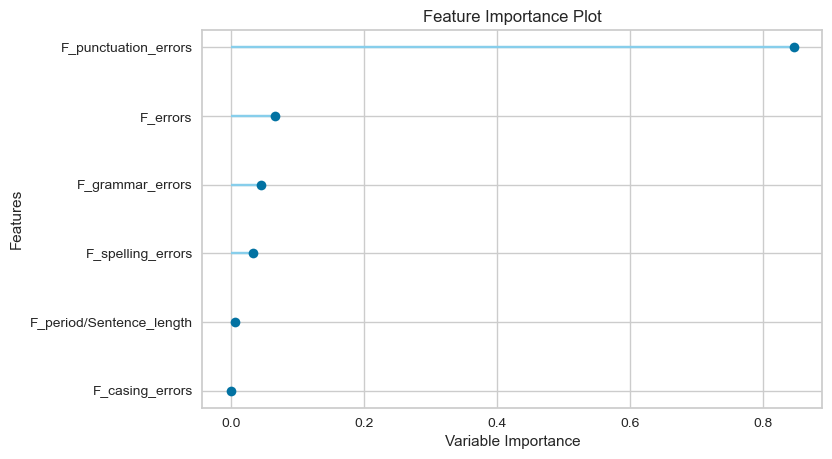

In [187]:
plot_model(all_tuned_models[0][0], 'feature')


In [172]:
from joblib import dump

Dumping for later use.

In [173]:
'''
dump(cohesion_best, 'saved_cohesion2')
dump(syntax_best, 'saved_syntax2')
dump(vocabulary_best, 'saved__vocabulary2')
dump(phraseology_best, 'saved_phraseology2')
dump(grammar_best, 'saved_grammar')
dump(conventions_best, 'saved_conventions')
'''

"\nsave_model(cohesion_best, 'saved_cohesion2')\nsave_model(syntax_best, 'saved_syntax2')\nsave_model(vocabulary_best, 'saved__vocabulary2')\nsave_model(phraseology_best, 'saved_phraseology2')\nsave_model(grammar_best, 'saved_grammar')\nsave_model(conventions_best, 'saved_conventions')\n"